In [10]:
from lib import *
from sklearn.metrics import mean_squared_error
import warnings
from scipy import stats
warnings.filterwarnings('ignore')

# from config import Config
class Config:
    res_path = '../results/'

m_name = 'nsgp'
sampling = 'cont' # cont, nn
Xcols = '@'.join(['longitude', 'latitude', 'humidity', 'temperature', 'weather', 'wind_direction', 'wind_speed', 'delta_t'])
kernel = 'rbf'
time_kernel = 'rbf'
common_path = lambda c_fold: '_@_'.join([m_name, c_fold, Xcols, sampling, kernel, time_kernel])
# common_path = lambda c_fold: 'one@hot@encoded'+c_fold
# ['longitude', 'latitude', 'humidity', 'temperature', 'weather', 'wind_direction', 'wind_speed', 'delta_t']

f_name = lambda fold: Config.res_path+common_path(fold)+'.csv'
f_name_res = lambda fold: Config.res_path+common_path(fold)+'.res'
f_name_model = lambda fold: Config.res_path+common_path(fold)+'.model'

def fold_wise_rmse(fold):
    test_data = pd.read_csv(f_name(fold))
    print('log:', test_data['pred_mean'].shape, test_data['pred_mean'].dropna().shape)
    print('loss', sum(pd.read_pickle(f_name_res(fold))['loss'][-5:-1])/4)
    test_data =test_data.dropna()
    for sid in test_data.station_id.unique():
        tmp_df = test_data[test_data.station_id==sid]
        print(sid, mean_squared_error(tmp_df['PM25_Concentration'], tmp_df['pred_mean'], squared=False))
    return 'fold', fold, 'RMSE', mean_squared_error(test_data['PM25_Concentration'], test_data['pred_mean'], squared=False)

def fold_wise_plots(fold):
    test_data = pd.read_csv(f_name(fold))
    for station in test_data.station_id.unique():
        plt.figure(figsize=(15,4))
        test_tmp = test_data[test_data.station_id == station]
        test_tmp['time'] = pd.to_datetime(test_tmp['time'])
        plt.plot(test_tmp['time'], test_tmp['PM25_Concentration'], label='ground truth');
        plt.plot(test_tmp['time'], test_tmp['pred_mean'], label='pred');
        plt.plot(test_tmp['time'], test_tmp['filled']*100, label='Is filled?');
        plt.title('Fold: '+str(fold)+' Station: '+str(station)+' t-test='+str(stats.ttest_rel(test_tmp['PM25_Concentration'], test_tmp['pred_mean'])))
        plt.xlabel('Time')
        plt.ylabel('PM2.5')
        plt.legend(bbox_to_anchor=(1,1))
#         plt.tight_layout()

f1 = fold_wise_rmse('0')[3]
f2 = fold_wise_rmse('1')[3]
f3 = fold_wise_rmse('2')[3]
' & '.join(map(lambda x: str(round(x, 2)), [f1, f2, f3, (f1+f2+f3)/3]))

log: (7440,) (7440,)
loss 0.5440852716565132
1003 15.543757701167282
1005 24.07839359753768
1006 14.251673937018191
1010 17.379610215523726
1011 19.883749824775563
1014 28.107951218547118
1018 25.084937722772604
1019 34.236729327554016
1030 19.31095635424136
1035 41.70233087535237
log: (7440,) (7440,)
loss 0.5739605575799942
1002 19.53966909284218
1004 19.176284985787888
1007 15.901429091745554
1023 19.28450630847563
1025 22.955642283029533
1029 38.44929203638458
1031 40.108356601622
1032 32.22607517436063
1033 30.428742988165386
1034 28.16121599378987
log: (7440,) (7440,)
loss 0.5423925817012787
1008 14.075251454088534
1012 25.09100594299325
1016 18.226142781171323
1017 20.53446172202501
1022 16.01024819275502
1024 17.70565888341684
1026 31.02429375802426
1027 23.47426895449501
1028 26.092648218818447
1036 46.279477959337335


'25.35 & 27.83 & 25.47 & 26.22'

In [11]:
for kernel in ['rbf', 'm12', 'm32']:
    print(kernel)
    for c_fold in ['0', '1', '2']:
        tmp_path = lambda c_fold: '_@_'.join([m_name, c_fold, Xcols, sampling, kernel, time_kernel])
#         tmp_path = lambda fold: 'one@hot@encoded'+fold
        f_name_res = lambda fold: Config.res_path+tmp_path(fold)+'.res'
        print(sum(pd.read_pickle(f_name_res(c_fold))['loss'][-5:-1])/4)
# model = torch.load(f_name_model('0'), map_location=torch.device('cpu'))
# model.period
# rbf
# 0.5874612331390381
# 0.6202627122402191
# 0.5620678439736366
# m12
# 0.6502028256654739
# 0.5803051590919495
# 0.648011639714241
# m32
# 0.588553711771965
# 0.6048360019922256
# 0.6710469126701355

rbf
0.5440852716565132
0.5739605575799942
0.5423925817012787
m12
0.5324723199009895
0.5525143444538116
0.5143363699316978
m32
0.5118401795625687
0.5871209055185318
0.5318118259310722


In [12]:
(23.48 + 25.18 + 25.47)/3

24.709999999999997

### Check variance

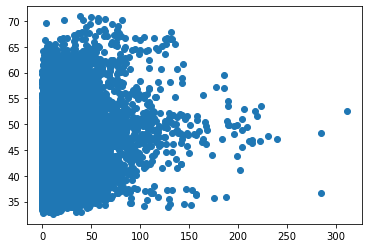

In [13]:
dfs = []
for fold in ['0', '1', '2']:
    dfs.append(pd.read_csv(f_name(fold)))
combo = pd.concat(dfs)

plt.scatter(np.abs(combo['PM25_Concentration'] - combo['pred_mean']), combo['pred_var']);

#24.45 & 25.58 & 25.77 & 25.27

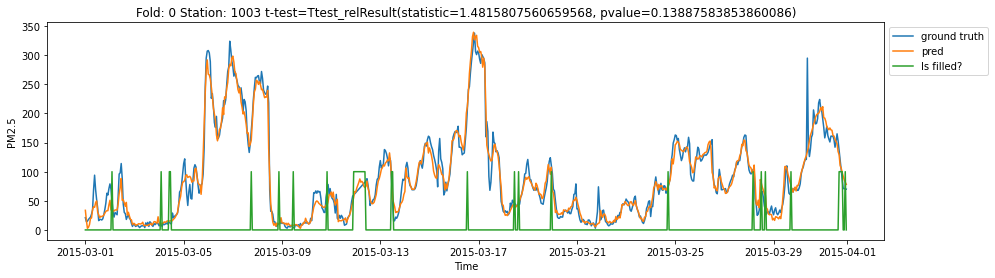

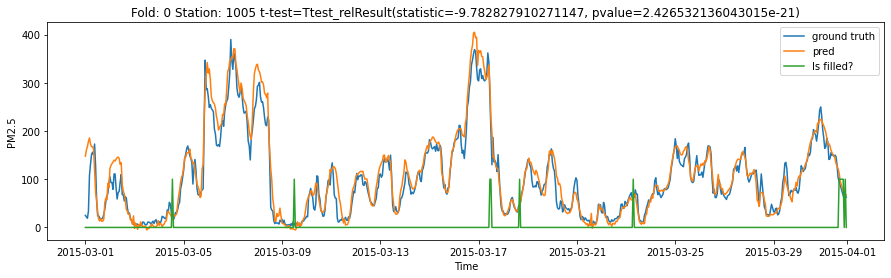

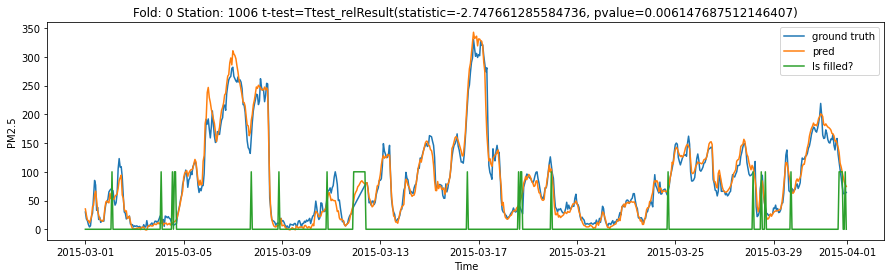

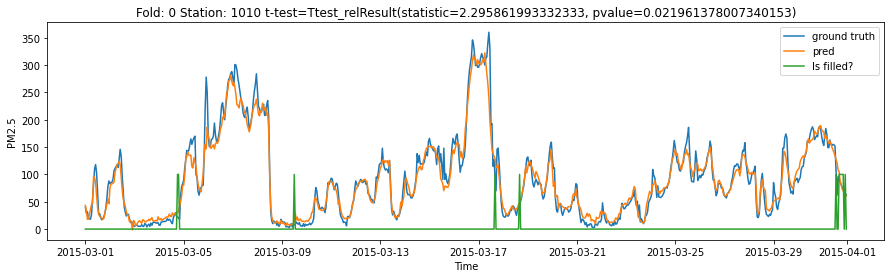

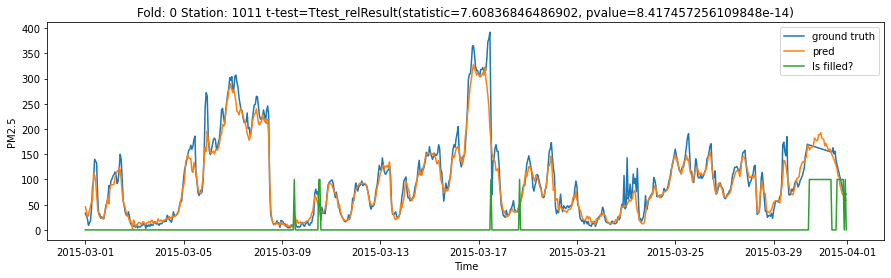

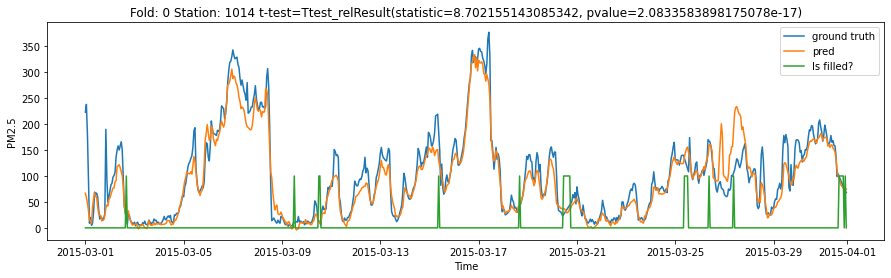

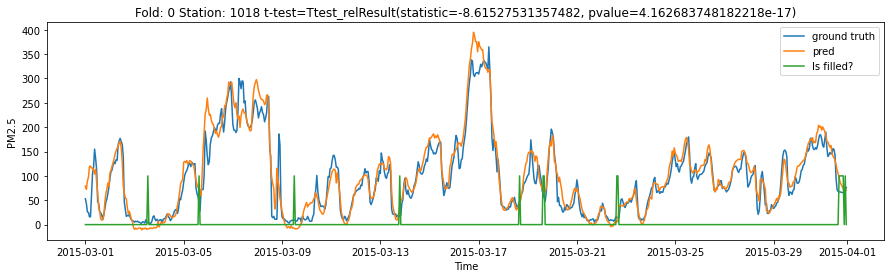

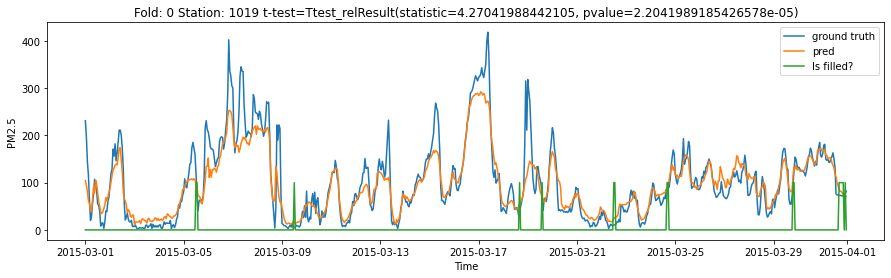

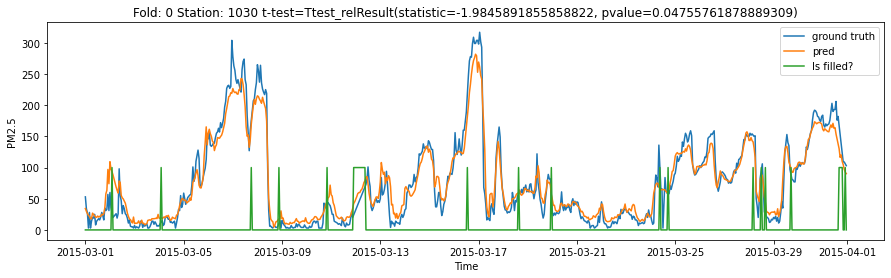

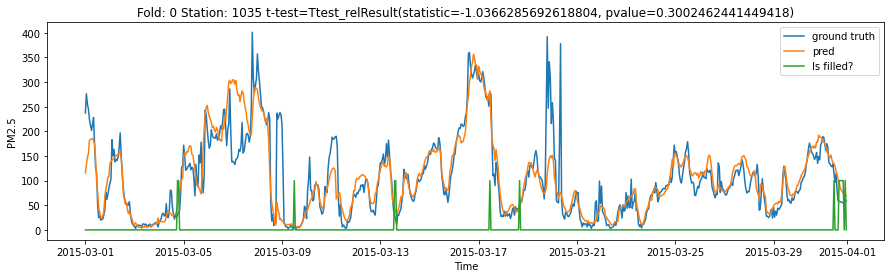

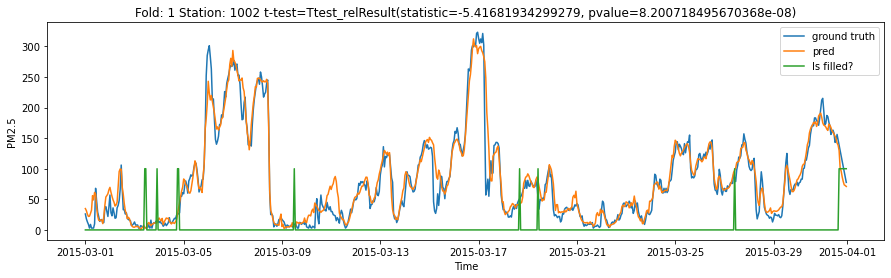

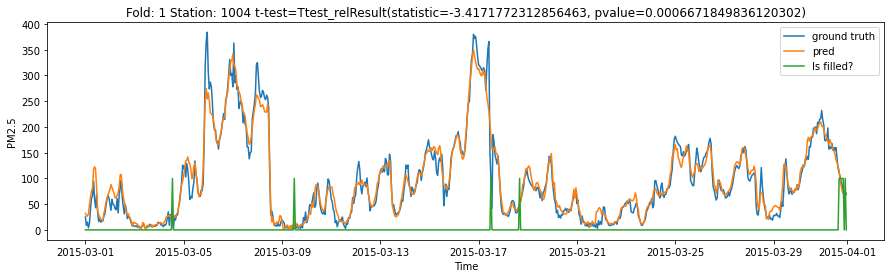

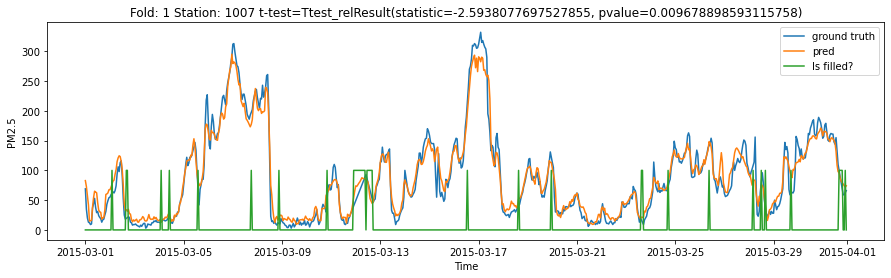

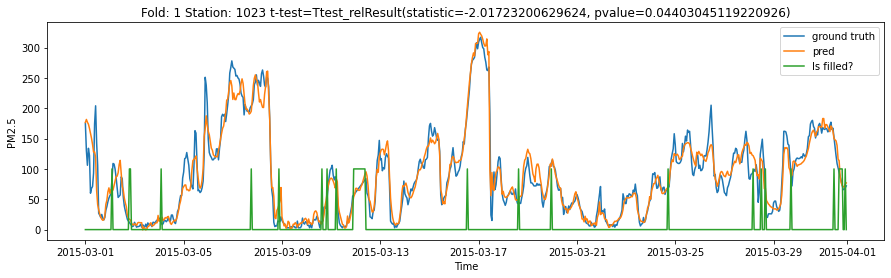

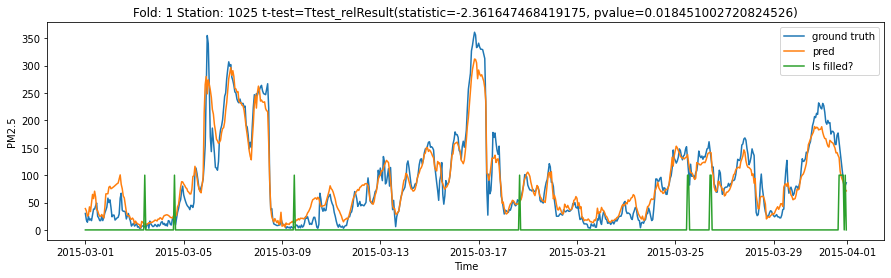

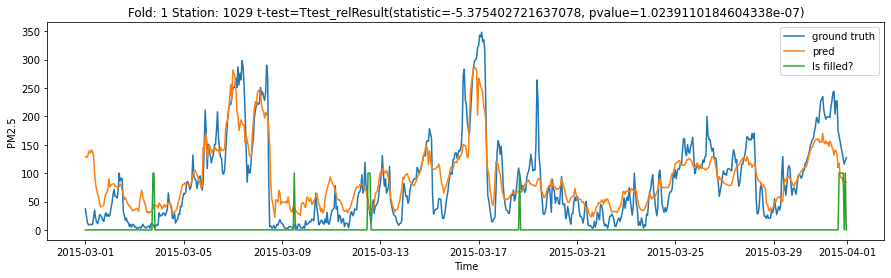

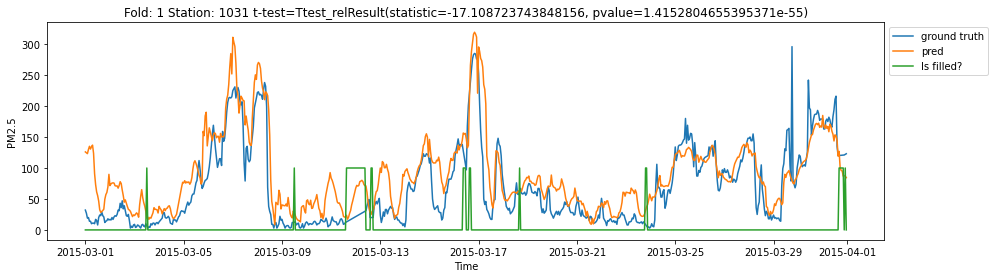

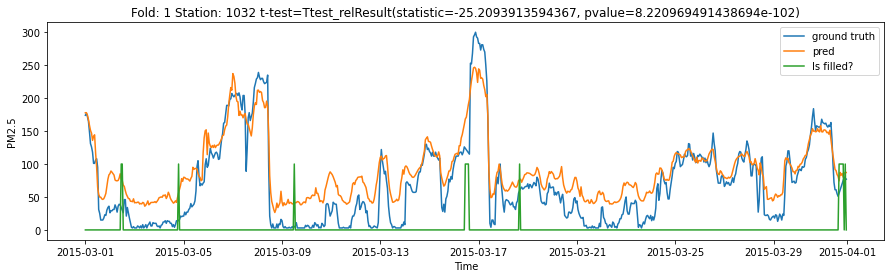

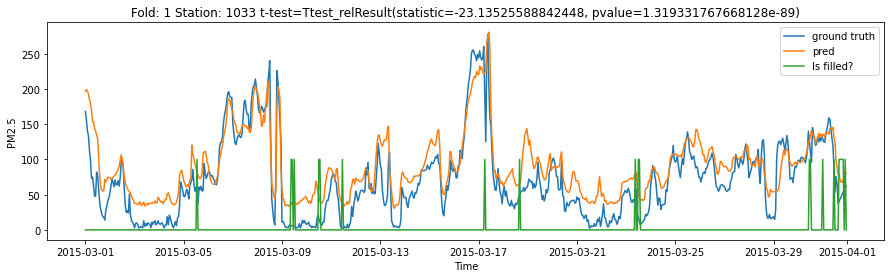

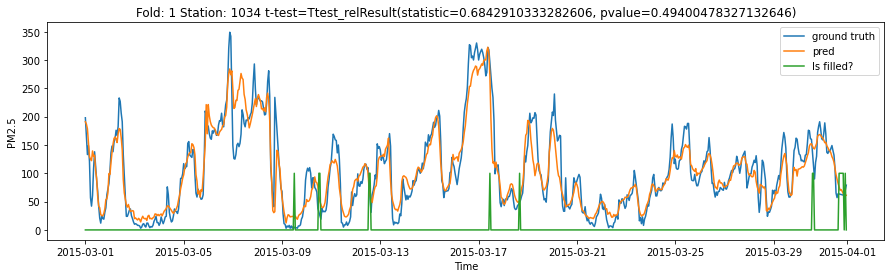

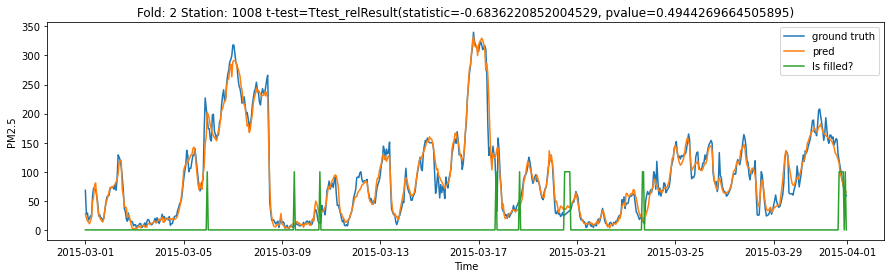

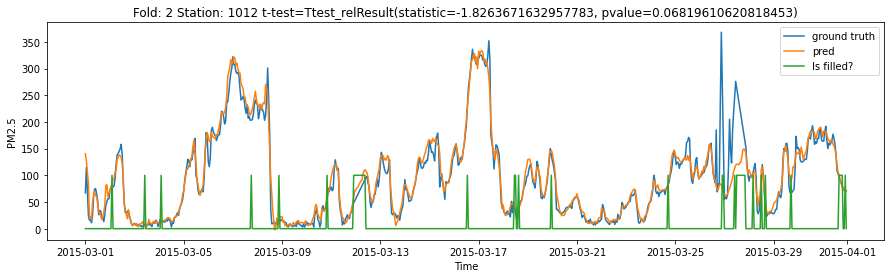

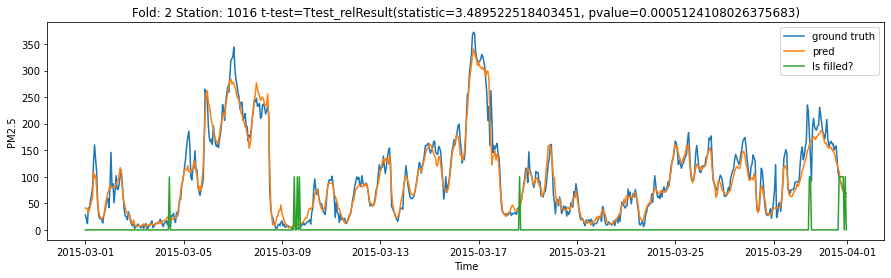

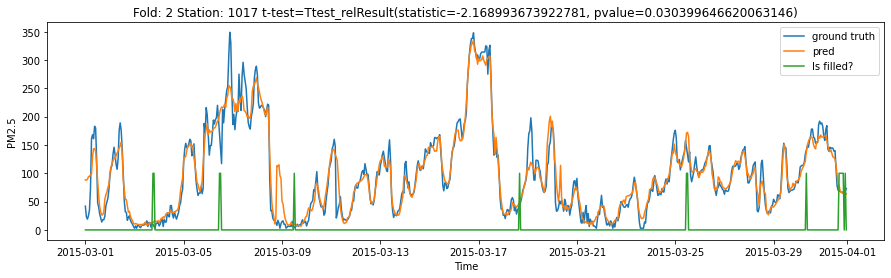

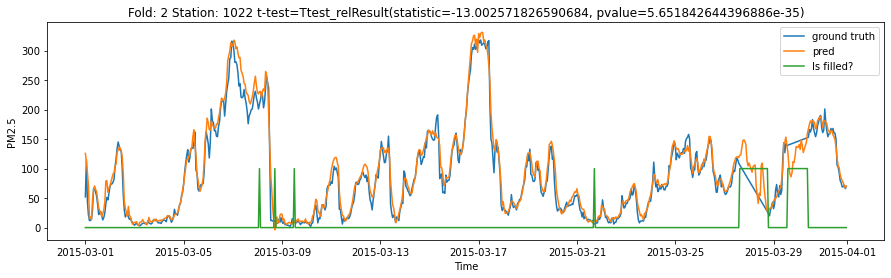

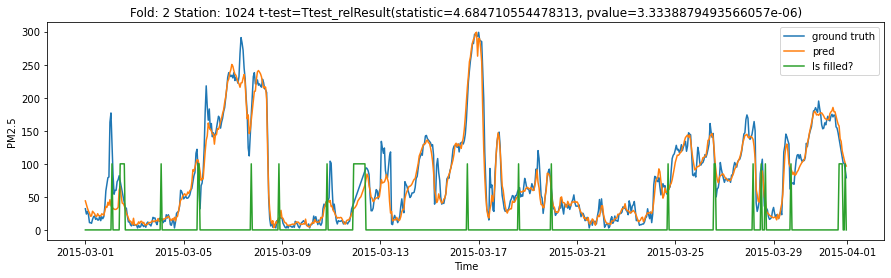

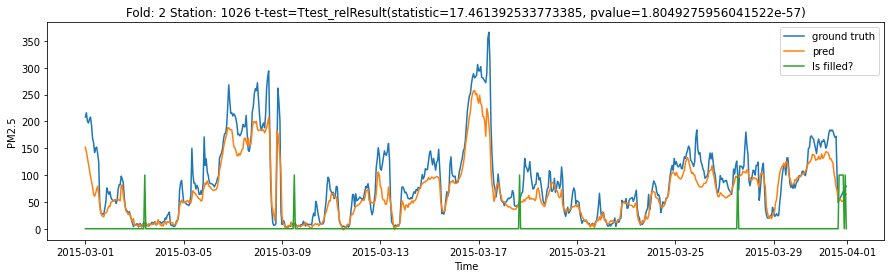

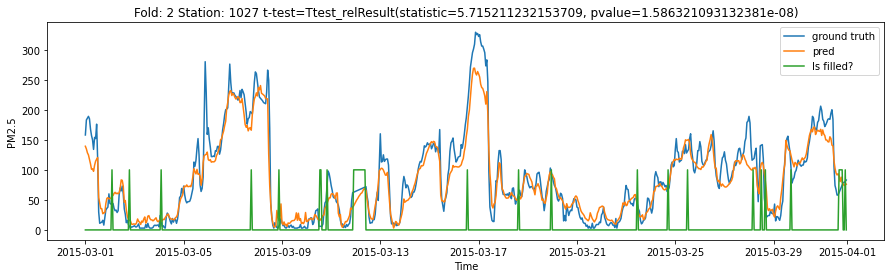

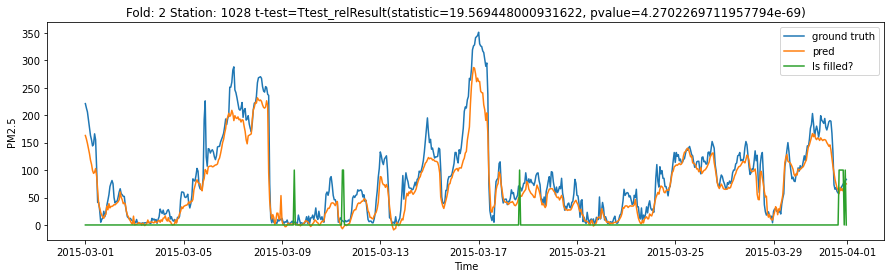

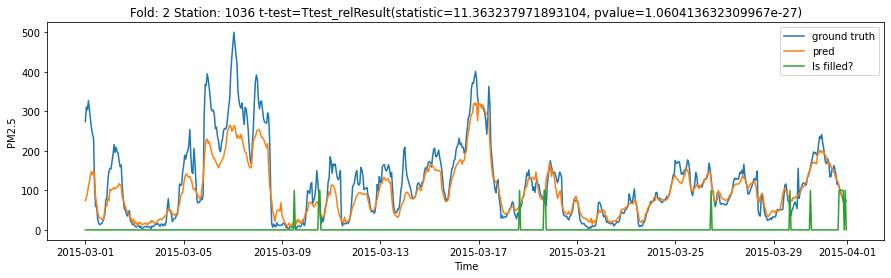

In [7]:
fold_wise_plots('0'), fold_wise_plots('1'), fold_wise_plots('2');

### Checking Loss

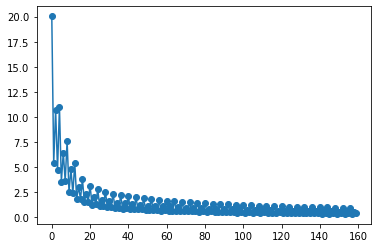

In [8]:
plt.plot(pd.read_pickle('../results/nsgp_@_0_@_longitude@latitude@humidity@temperature@weather@wind_direction@wind_speed@delta_t_@_cont_@_m12_@_loc_periodic.res')['loss'], 'o-');

### Checking anomalies

In [9]:
fold = '2'
test_data = pd.read_csv('../results/gp_res_fold'+fold+'.csv')
tmp_df = test_data[test_data.station_id == 1010]
plt.plot(tmp_df['PM25_Concentration']);
plt.plot(tmp_df['filled']*100);
# tmp_df

FileNotFoundError: [Errno 2] No such file or directory: '../results/gp_res_fold2.csv'

### Appendix

In [11]:
import torch
import sys
fold = '1'
path = '../results/nsgp_@_'+fold+'_@_longitude@latitude@humidity@temperature@weather@wind_direction@wind_speed@delta_t_@_cont_@_rbf_@_rbf.model'
m = torch.load(path, map_location=torch.device('cpu'))
res = pd.read_pickle(path.replace('model', 'res'))

In [12]:
m.eval()

test_X, test_y = res['dataloader'].load_test()

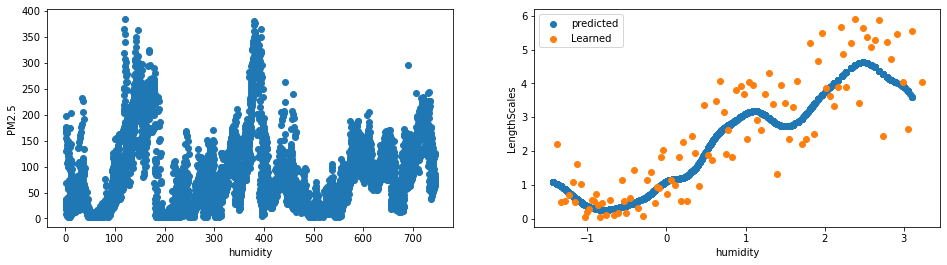

In [17]:
dim = 2
fets = ['longitude', 'latitude', 'humidity', 'temperature', 'weather', 'wind_direction', 'wind_speed', 'delta_t']
with torch.no_grad():
    pred_LS = m.get_LS(test_X, dim)

fig, ax = plt.subplots(1,2,figsize=(16,4))
ax[0].scatter(res['dataloader'].Xscaler.inverse_transform(test_X[:, [0,1,2,3,6,7]])[:, -1], test_y);
ax[0].set_xlabel(fets[dim])
ax[0].set_ylabel('PM2.5')
# plt.figure()
ax[1].scatter(test_X[:, dim], pred_LS, label='predicted');
with torch.no_grad():
    ax[1].scatter(m.X_bar[dim], m.local_ls[dim], label='Learned')
    ax[1].set_xlabel(fets[dim])
    ax[1].set_ylabel('LengthScales')
    ax[1].legend()
    pass

In [29]:
train_data = pd.read_csv("../../data/time_feature/fold0/train_data.csv.gz")
test_data = pd.read_csv("../../data/time_feature/fold0/test_data.csv.gz")
test_output = pd.read_csv('../../data/time_feature/fold0/test_output.csv.gz')

test_data['PM25_Concentration'] = test_output['PM25_Concentration']
display(train_data.head(2), test_data.head(2))

,station_id,longitude,latitude,PM25_Concentration,temperature,humidity,wind_speed,weather_0.0,weather_1.0,weather_2.0,...,wind_direction_1.0,wind_direction_2.0,wind_direction_3.0,wind_direction_4.0,wind_direction_9.0,wind_direction_13.0,wind_direction_14.0,wind_direction_23.0,wind_direction_24.0,delta_t
0,1001,116.173553,40.090679,138.0,20.0,56.0,7.92,1,0,0,...,0,0,0,0,0,1,0,0,0,1
1,1002,116.205310,40.003950,89.0,20.0,56.0,7.92,1,0,0,...,0,0,0,0,0,1,0,0,0,1


,station_id,longitude,latitude,PM25_Concentration,temperature,humidity,wind_speed,weather_0.0,weather_1.0,weather_2.0,...,wind_direction_1.0,wind_direction_2.0,wind_direction_3.0,wind_direction_4.0,wind_direction_9.0,wind_direction_13.0,wind_direction_14.0,wind_direction_23.0,wind_direction_24.0,delta_t
0,1003,116.184239,39.914409,105.0,20.0,56.0,7.92,1,0,0,...,0,0,0,0,0,1,0,0,0,1
1,1006,116.287451,39.987313,87.0,20.0,56.0,7.92,1,0,0,...,0,0,0,0,0,1,0,0,0,1


In [ ]:
def latexify(fig_width=None, fig_height=None, columns=1):
    """Set up matplotlib's RC params for LaTeX plotting.
    Call this before plotting a figure.

    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    """

    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples

    # Width and max height in inches for IEEE journals taken from
    # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

    assert(columns in [1,2])

    if fig_width is None:
        fig_width = 3.39 if columns==1 else 6.9 # width in inches

    if fig_height is None:
        golden_mean = (sqrt(5)-1.0)/2.0    # Aesthetic ratio
        fig_height = fig_width*golden_mean # height in inches

    MAX_HEIGHT_INCHES = 8.0
    if fig_height > MAX_HEIGHT_INCHES:
        print("WARNING: fig_height too large:" + fig_height + 
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
        fig_height = MAX_HEIGHT_INCHES

    params = {'backend': 'ps',
              'text.latex.preamble': [r'\usepackage{gensymb}'],
              'axes.labelsize': 10, # fontsize for x and y labels (was 10)
              'axes.titlesize': 10,
              'font.size': 10, # was 10
              'legend.fontsize': 10, # was 10
              'xtick.labelsize': 10,
              'ytick.labelsize': 10,
              'text.usetex': True,
              'figure.figsize': [fig_width,fig_height],
              'font.family': 'serif'
    }

    matplotlib.rcParams.update(params)


def format_axes(ax):

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    for spine in ['left', 'bottom']:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction='out', color=SPINE_COLOR)

    return ax